In [ ]:
# =============================================================================
# NLP Final Project: Robust Sentiment Analysis Under Noisy Text
# Team: Anusha NagaNaik, Samanthaka Manognya Tadikonda
# Course: INFO 7610 - Natural Language Processing, Northeastern University
# =============================================================================

# PIPELINE OVERVIEW:
# 1. Setup & Environment Detection (Colab / Local)
# 2. Model Training - Train DistilBERT on CLEAN IMDB training data
# 3. Save & Download Model
# 4. Load Clean Test Reviews
# 5. Noise Injection - Add synthetic noise to test reviews
# 6. LLM Cleaning - Clean with BOTH Claude AND GPT for comparison
# 7. Load Trained Model
# 8. Evaluation - Test on Clean, Noisy, Claude-Cleaned, and GPT-Cleaned text
# 9. Visualization - Generate charts comparing all conditions

In [ ]:
# =============================================================================
# Environment Setup & Library Installation
# Detects if running on Colab or local, installs required packages
# =============================================================================

import sys
import os

# Detect environment
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Running on Google Colab")
    # Install required libraries on Colab
    !pip install transformers datasets torch scikit-learn matplotlib anthropic openai -q
    print("All libraries installed")
else:
    print("Running on Local Machine")
    print("Make sure you have installed: transformers datasets torch scikit-learn matplotlib anthropic openai")
    print("Install with: pip install transformers datasets torch scikit-learn matplotlib anthropic openai")

# Standard imports
import time
import random
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns

# GPU Optimization Setup
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True  # 8x speedup on A100
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠ No GPU detected")

print("Environment setup complete")

Running on Google Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 11.8 MB/s eta 0:00:00
All libraries installed
✓ GPU: Tesla T4
✓ Memory: 15.83 GB
Environment setup complete


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [ ]:
# =============================================================================
# Train DistilBERT Model on Clean Data
# OPTIMIZED FOR A100 GPU - FULL 25K TRAINING SET
# =============================================================================

print("Model Training on Clean IMDB Data")

if not IS_COLAB:
    print("Warning: Training on local machine may be slow without GPU")
    print("Recommended: Run this cell on Google Colab with GPU enabled")
    print("(Runtime > Change runtime type > GPU)")

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# Load IMDB training data
print("Loading IMDB training data...")
dataset = load_dataset("imdb")

# Use ALL 25,000 samples for training (80/20 train/val split)
full_train = dataset['train'].shuffle(seed=42)  # Use .select(range(10000)) if needed.

train_size = int(0.8 * len(full_train))  # 20,000 for training
val_size = len(full_train) - train_size  # 5,000 for validation

train_dataset = full_train.select(range(train_size))
val_dataset = full_train.select(range(train_size, train_size + val_size))

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Load tokenizer and tokenize data
print("Loading DistilBERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

print("Tokenizing data (this may take a few minutes)...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
print("Data tokenized")

# Load model
print("Loading DistilBERT model...")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2  # Binary classification (positive/negative)
)

# Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training configuration - OPTIMIZED FOR A100 with Early Stopping
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,

    # A100 GPU Settings
    per_device_train_batch_size=128,
    per_device_eval_batch_size=256,
    fp16=True,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,

    # For T4 GPU, uncomment these instead:
    # per_device_train_batch_size=16,
    # per_device_eval_batch_size=32,

    # Evaluation & Saving
    eval_strategy="steps",
    eval_steps=150,
    save_strategy="steps",
    save_steps=150,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,

    # Logging & Optimization
    logging_steps=50,
    report_to="none",
    warmup_steps=500,
    weight_decay=0.01,
)

# Initialize trainer with Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting training with early stopping...")
print("Training on FULL 25K dataset - up to 10 epochs")
print("Expected time: 5-10 minutes on A100 GPU")

# Train the model
trainer.train()

print("Training complete")

# Show final validation results
print("\nFinal Validation Results:")
eval_results = trainer.evaluate()
for key, value in eval_results.items():
    if 'eval_' in key:
        print(f"  {key.replace('eval_', ''):12}: {value:.4f}")

# Save the trained model
print("Saving model...")
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")
print("Model saved to './sentiment_model'")

Model Training on Clean IMDB Data
Loading IMDB training data...
Training samples: 20000
Validation samples: 5000
Loading DistilBERT tokenizer...
Tokenizing data (this may take a few minutes)...


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Data tokenized
Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training with early stopping...
Training on FULL 25K dataset - up to 10 epochs
Expected time: 5-10 minutes on A100 GPU


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
150,0.274100,0.313467,0.868800,0.961877,0.772977,0.857143
300,0.225100,0.208915,0.919000,0.935340,0.903378,0.919081
450,0.149500,0.223237,0.915400,0.883628,0.960330,0.920384
600,0.109800,0.220169,0.926400,0.917561,0.939906,0.928599
750,0.068400,0.253816,0.926600,0.937024,0.917518,0.927168
900,0.034500,0.282171,0.927200,0.913571,0.946583,0.929784
1050,0.028100,0.308306,0.927800,0.928263,0.930086,0.929174
1200,0.011500,0.351682,0.928200,0.924002,0.935978,0.929951
1350,0.011200,0.341796,0.931000,0.926716,0.938727,0.932683
1500,0.010100,0.353239,0.932000,0.931534,0.935192,0.933359


Training complete

Final Validation Results:


  loss        : 0.3532
  accuracy    : 0.9320
  precision   : 0.9315
  recall      : 0.9352
  f1          : 0.9334
  runtime     : 2.9298
  samples_per_second: 1706.6150
  steps_per_second: 6.8260
Saving model...
Model saved to './sentiment_model'


In [ ]:
# =============================================================================
# Download Model (Colab)
# Creates zip file and downloads on Colab for use in later sessions
# =============================================================================

print("\nSave and Download Model")

if IS_COLAB:
    import shutil
    from google.colab import files

    print("Creating zip file for download...")
    shutil.make_archive('sentiment_model', 'zip', '.', 'sentiment_model')
    files.download('sentiment_model.zip')
    print("Model downloaded - save this file")
    print("You can upload this to run evaluation on Colab or locally")
else:
    print("Model saved locally at './sentiment_model'")
    print("You can use this model for evaluation without retraining")


Save and Download Model
Creating zip file for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded - save this file
You can upload this to run evaluation on Colab or locally


In [ ]:
# =============================================================================
# Load Clean Test Reviews
# Downloads IMDB test set and saves 1000 clean reviews for testing
# =============================================================================

print("\nLoading Clean Test Reviews")

# Load IMDB test data
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")
print(f"Loaded {len(dataset['test'])} test reviews")

# Sample 1000 reviews for testing (change this number for experimentation)
TEST_SIZE = 1000
test_data = dataset['test'].shuffle(seed=42).select(range(TEST_SIZE))

# Create DataFrame
df = pd.DataFrame({
    'text': test_data['text'],
    'label': test_data['label']
})

# Save clean reviews
df.to_csv('clean_reviews.csv', index=False)
print(f"Saved {len(df)} clean reviews to 'clean_reviews.csv'")

# Show first review example
print("\nExample Review (first 200 chars):")
print(df['text'].iloc[0][:200] + "...")

# Download on Colab (optional on local)
if IS_COLAB:
    from google.colab import files
    files.download('clean_reviews.csv')
    print("File downloaded")


Loading Clean Test Reviews
Loading IMDB dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loaded 25000 test reviews
Saved 1000 clean reviews to 'clean_reviews.csv'

Example Review (first 200 chars):
<br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quic...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded


In [ ]:
# =============================================================================
# Noise Injection Setup and Application
# Adds synthetic noise to test reviews to simulate real-world messy text
# =============================================================================

print("\nNoise Injection Setup")

# ----- CHARACTER-LEVEL NOISE FUNCTIONS -----

def add_typos(text):
    """Swap adjacent letters in 20% of words (simulate typing errors)"""
    words = text.split()
    noisy_words = []

    for word in words:
        if len(word) > 3 and random.random() < 0.2:
            idx = random.randint(0, len(word)-2)
            word_list = list(word)
            word_list[idx], word_list[idx+1] = word_list[idx+1], word_list[idx]
            word = ''.join(word_list)
        noisy_words.append(word)

    return ' '.join(noisy_words)

def elongate_words(text):
    """Elongate vowels in 15% of words (e.g., 'good' -> 'goood')"""
    words = text.split()
    noisy_words = []

    for word in words:
        if len(word) > 3 and random.random() < 0.15:
            for i, char in enumerate(word):
                if char in 'aeiouAEIOU':
                    word = word[:i] + char*3 + word[i+1:]
                    break
        noisy_words.append(word)

    return ' '.join(noisy_words)

def add_keyboard_typos(text):
    """Simulate adjacent key presses on QWERTY keyboard"""
    keyboard_neighbors = {
        'a': 'sqwz', 'b': 'vghn', 'c': 'xdfv', 'd': 'sfcxe', 'e': 'rdsw',
        'f': 'dgcvr', 'g': 'fhtbv', 'h': 'gjnby', 'i': 'oukj', 'j': 'hknui',
        'k': 'jlmio', 'l': 'kop', 'm': 'njk', 'n': 'bhjm', 'o': 'ipkl',
        'p': 'ol', 'q': 'wa', 'r': 'tfde', 's': 'awedxz', 't': 'rgfy',
        'u': 'yihj', 'v': 'cfgb', 'w': 'qase', 'x': 'zsdc', 'y': 'tugh',
        'z': 'asx'
    }

    words = text.split()
    noisy_words = []

    for word in words:
        if len(word) > 3 and random.random() < 0.1:
            idx = random.randint(0, len(word)-1)
            char = word[idx].lower()
            if char in keyboard_neighbors:
                new_char = random.choice(keyboard_neighbors[char])
                word = word[:idx] + new_char + word[idx+1:]
        noisy_words.append(word)

    return ' '.join(noisy_words)

def delete_chars(text):
    """Randomly delete characters from 10% of words"""
    words = text.split()
    noisy_words = []

    for word in words:
        if len(word) > 4 and random.random() < 0.1:
            idx = random.randint(1, len(word)-2)
            word = word[:idx] + word[idx+1:]
        noisy_words.append(word)

    return ' '.join(noisy_words)

def insert_chars(text):
    """Randomly insert characters into 10% of words"""
    words = text.split()
    noisy_words = []

    for word in words:
        if len(word) > 3 and random.random() < 0.1:
            idx = random.randint(1, len(word)-1)
            char = random.choice('abcdefghijklmnopqrstuvwxyz')
            word = word[:idx] + char + word[idx:]
        noisy_words.append(word)

    return ' '.join(noisy_words)

def add_random_caps(text):
    """Randomly capitalize letters (e.g., 'movie' -> 'mOvIe')"""
    words = text.split()
    noisy_words = []

    for word in words:
        if len(word) > 3 and random.random() < 0.15:
            word = ''.join([c.upper() if random.random() < 0.3 else c for c in word])
        noisy_words.append(word)

    return ' '.join(noisy_words)

# ----- WORD-LEVEL NOISE FUNCTIONS -----

def add_slang(text):
    """Replace common words with internet slang"""
    slang_map = {
        # Intensifiers
        ' really ': ' fr fr ',
        ' very ': ' hella ',
        ' so ': ' lowkey ',
        ' extremely ': ' deadass ',
        ' absolutely ': ' facts ',
        ' totally ': ' legit ',
        ' quite ': ' kinda ',

        # Positive words
        ' good ': ' fire ',
        ' great ': ' goated ',
        ' awesome ': ' bussin ',
        ' amazing ': ' slaps ',
        ' excellent ': ' valid ',
        ' wonderful ': ' hits different ',
        ' fantastic ': ' no cap ',
        ' perfect ': ' chef kiss ',
        ' beautiful ': ' aesthetic ',
        ' cool ': ' dope ',
        ' fun ': ' lit ',
        ' funny ': ' hilarious ngl ',
        ' interesting ': ' lowkey interesting ',

        # Negative words
        ' bad ': ' trash ',
        ' terrible ': ' ass ',
        ' awful ': ' mid ',
        ' horrible ': ' straight garbage ',
        ' boring ': ' mid af ',
        ' stupid ': ' dumb af ',
        ' annoying ': ' cringe ',
        ' disappointing ': ' L ',
        ' worst ': ' trash tier ',
        ' weak ': ' weak sauce ',

        # Emotions
        ' love ': ' stan ',
        ' like ': ' fw ',
        ' hate ': ' can\'t stand ',
        ' enjoy ': ' vibe with ',
        ' sad ': ' dead inside ',
        ' happy ': ' vibing ',
        ' angry ': ' tilted ',
        ' scared ': ' shook ',
        ' excited ': ' hyped ',

        # Other common words
        ' thing ': ' joint ',
        ' person ': ' dude ',
        ' people ': ' folks ',
        ' money ': ' bread ',
        ' understand ': ' get ',
        ' believe ': ' buy ',
        ' watch ': ' peep ',
        ' look ': ' peep ',
        ' think ': ' reckon ',
    }

    for word, slang in slang_map.items():
        text = text.replace(word, slang)

    return text

def add_word_dropout(text):
    """Randomly remove 5% of words"""
    words = text.split()
    filtered_words = [w for w in words if random.random() > 0.05]
    return ' '.join(filtered_words)

def add_word_repeat(text):
    """Randomly repeat 5% of words"""
    words = text.split()
    noisy_words = []

    for word in words:
        noisy_words.append(word)
        if random.random() < 0.05:
            noisy_words.append(word)

    return ' '.join(noisy_words)

def add_word_swap(text):
    """Randomly swap adjacent words"""
    words = text.split()
    if len(words) < 2:
        return text

    i = 0
    while i < len(words) - 1:
        if random.random() < 0.05:
            words[i], words[i+1] = words[i+1], words[i]
            i += 2
        else:
            i += 1

    return ' '.join(words)

# ----- OTHER NOISE FUNCTIONS -----

def add_emojis(text):
    """Add random emojis to end of text"""
    emojis = ['😭', '🔥', '💀', '😂', '💘', '😩', '💯', '😍']
    num_emojis = random.randint(1, 3)
    for _ in range(num_emojis):
        text += ' ' + random.choice(emojis)
    return text

def remove_punctuation(text):
    """Remove all punctuation marks"""
    import string
    return text.translate(str.maketrans('', '', string.punctuation))


# ----- NOISE CONFIGURATION -----
# Enable/disable noise types for easy experimentation
# Set to True to enable, False to disable

NOISE_CONFIG = {
    # Character-level noise (realistic moderate noise)
    'typos': True,              # Swap adjacent letters - common typing errors
    'elongation': True,         # Repeat vowels (goood) - common in social media
    'keyboard_typos': True,     # Adjacent key mistakes - realistic typos
    'delete_chars': False,      # Remove random characters - too aggressive
    'insert_chars': False,      # Add random characters - too aggressive
    'random_caps': True,        # Mix upper/lowercase - common in informal text

    # Word-level noise (realistic social media style)
    'slang': True,              # Replace with internet slang - very common
    'word_dropout': True,       # Remove random words - happens in quick typing
    'word_repeat': False,       # Duplicate words - less common
    'word_swap': False,         # Swap adjacent words - less common

    # Other noise
    'emojis': False,            # Add emojis (disable per professor request)
    'remove_punctuation': False # Strip punctuation - too aggressive
}

def add_all_noise(text):
    """Apply all enabled noise types based on NOISE_CONFIG"""
    # Character-level noise
    if NOISE_CONFIG['typos']:
        text = add_typos(text)
    if NOISE_CONFIG['elongation']:
        text = elongate_words(text)
    if NOISE_CONFIG['keyboard_typos']:
        text = add_keyboard_typos(text)
    if NOISE_CONFIG['delete_chars']:
        text = delete_chars(text)
    if NOISE_CONFIG['insert_chars']:
        text = insert_chars(text)
    if NOISE_CONFIG['random_caps']:
        text = add_random_caps(text)

    # Word-level noise
    if NOISE_CONFIG['slang']:
        text = add_slang(text)
    if NOISE_CONFIG['word_dropout']:
        text = add_word_dropout(text)
    if NOISE_CONFIG['word_repeat']:
        text = add_word_repeat(text)
    if NOISE_CONFIG['word_swap']:
        text = add_word_swap(text)

    # Other noise
    if NOISE_CONFIG['emojis']:
        text = add_emojis(text)
    if NOISE_CONFIG['remove_punctuation']:
        text = remove_punctuation(text)

    return text

# Display active noise types
print("Active noise types:")
for noise_type, enabled in NOISE_CONFIG.items():
    if enabled:
        print(f"  - {noise_type}")

print("Noise functions ready")

# Apply noise to test reviews
print("\nApplying Noise to Test Reviews")

# Load clean reviews
df = pd.read_csv('clean_reviews.csv')

# Add noise to each review
print(f"Adding noise to {len(df)} reviews...")
df['noisy_text'] = df['text'].apply(add_all_noise)

# Save noisy reviews
df.to_csv('noisy_reviews.csv', index=False)
print("Saved noisy reviews to 'noisy_reviews.csv'")

# Show examples of clean vs noisy
print("\nClean vs Noisy Examples:")

for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"CLEAN: {df['text'].iloc[i][:150]}...")
    print(f"NOISY: {df['noisy_text'].iloc[i][:150]}...")

# Download on Colab (optional on local)
if IS_COLAB:
    from google.colab import files
    files.download('noisy_reviews.csv')
    print("File downloaded")


Noise Injection Setup
Active noise types:
  - typos
  - elongation
  - keyboard_typos
  - random_caps
  - slang
  - word_dropout
Noise functions ready

Applying Noise to Test Reviews
Adding noise to 1000 reviews...
Saved noisy reviews to 'noisy_reviews.csv'

Clean vs Noisy Examples:

Example 1:
CLEAN: <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was i...
NOISY: <br /><bR />Wehn I unsuspectedly rejted A ThousanD Acres, I ghought I was for an entertaining King Laer story and of course Pfeiffer was in it, lowkey...

Example 2:
CLEAN: This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was launched in t...
NOISY: Thiiis is the laaatest eeentry in the lonf seriEs of fiiilms aith the Frdeench agent, O.S.S. 117 (the French Answsr to James Booond). The series was l...

Example 3:
CLEAN: This movie was so frustratin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded


In [ ]:
# =============================================================================
# LLM-Based Cleaning Configuration
# Setup for cleaning noisy text using BOTH Claude AND GPT for comparison
# =============================================================================

print("\nLLM Cleaning Setup")

# API Keys - REPLACE WITH YOUR OWN KEYS
# CLAUDE_API_KEY = "your-claude-api-key-here"
# OPENAI_API_KEY = "your-openai-api-key-here"

# ----- LLM CLEANING FUNCTIONS -----

def clean_with_claude(text):
    """Clean noisy text using Claude Haiku (fast and cheap)"""
    import anthropic
    client = anthropic.Anthropic(api_key=CLAUDE_API_KEY)

    message = client.messages.create(
        model="claude-haiku-4-5-20251001",  # Fast model for cleaning
        max_tokens=1024,
        messages=[{
            "role": "user",
            "content": f"Rewrite this movie review in standard English. Fix all typos, replace slang with proper words, fix elongated words, fix capitalization. Keep the exact same sentiment (positive/negative). Only return the cleaned review:\n\n{text}"
        }]
    )
    return message.content[0].text.strip()

def clean_with_openai(text):
    """Clean noisy text using OpenAI GPT"""
    from openai import OpenAI
    client = OpenAI(api_key=OPENAI_API_KEY)

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        max_tokens=1024,
        messages=[{
            "role": "user",
            "content": f"Rewrite this movie review in standard English. Fix all typos, replace slang with proper words, fix elongated words, fix capitalization. Keep the exact same sentiment (positive/negative). Only return the cleaned review:\n\n{text}"
        }]
    )
    return response.choices[0].message.content.strip()

print("Note: Cleaning with BOTH LLMs will take 60-120 minutes for 1000 reviews")
print("Cost: Approximately $10-20 total for both providers")


LLM Cleaning Setup
Note: Cleaning with BOTH LLMs will take 60-120 minutes for 1000 reviews
Cost: Approximately $10-20 total for both providers


In [ ]:
# =============================================================================
# Clean Noisy Reviews with Claude
# Processes all noisy reviews through Claude Haiku
# Includes retry logic and progress saving
# =============================================================================

print("\nClaude Cleaning Process")

# Load noisy reviews
df = pd.read_csv('noisy_reviews.csv')

# Check if we're resuming from a previous run
if 'claude_cleaned' in df.columns:
    claude_cleaned_reviews = df['claude_cleaned'].tolist()
    # Find where we left off
    start_from = 0
    for idx, val in enumerate(claude_cleaned_reviews):
        if val == '' or pd.isna(val):
            start_from = idx
            break
        start_from = idx + 1
    print(f"Resuming Claude cleaning from review {start_from}")
else:
    claude_cleaned_reviews = [''] * len(df)
    start_from = 0
    print(f"Starting Claude cleaning from review 0")

print(f"Total reviews: {len(df)}")
print(f"Remaining: {len(df) - start_from}")

# Clean each review with Claude
for i in range(start_from, len(df)):
    noisy_text = df['noisy_text'].iloc[i]

    # Progress update every 25 reviews
    if i % 25 == 0:
        print(f"Claude progress: {i}/{len(df)} reviews cleaned...")

    # Retry mechanism for API errors
    retry_count = 0
    max_retries = 3

    while retry_count < max_retries:
        try:
            cleaned = clean_with_claude(noisy_text)
            claude_cleaned_reviews[i] = cleaned
            break  # Success, move to next review

        except Exception as e:
            error_str = str(e).lower()

            # Check for rate limit / overload errors
            if "overloaded" in error_str or "529" in error_str or "rate" in error_str:
                retry_count += 1
                if retry_count < max_retries:
                    print(f"  Claude API busy at review {i}, waiting 10 seconds... (retry {retry_count}/{max_retries})")
                    time.sleep(10)
                else:
                    print(f"  Skipping review {i} after {max_retries} retries")
                    claude_cleaned_reviews[i] = noisy_text  # Keep noisy if all retries fail
            else:
                # Other errors - don't retry
                print(f"  Error at review {i}: {e}")
                claude_cleaned_reviews[i] = noisy_text
                break

    # Delay between API requests
    time.sleep(2)

    # Save progress every 100 reviews
    if i % 100 == 0 and i > 0:
        df['claude_cleaned'] = claude_cleaned_reviews
        df.to_csv('claude_cleaned_progress.csv', index=False)
        print(f"  Claude progress saved at review {i}")

# Final save
df['claude_cleaned'] = claude_cleaned_reviews
df.to_csv('claude_cleaned_reviews.csv', index=False)

print("All reviews cleaned with Claude")
print("Saved to 'claude_cleaned_reviews.csv'")

# Download on Colab
if IS_COLAB:
    from google.colab import files
    files.download('claude_cleaned_reviews.csv')
    print("File downloaded")


Claude Cleaning Process
Starting Claude cleaning from review 0
Total reviews: 1000
Remaining: 1000
Claude progress: 0/1000 reviews cleaned...
Claude progress: 25/1000 reviews cleaned...
Claude progress: 50/1000 reviews cleaned...
Claude progress: 75/1000 reviews cleaned...
Claude progress: 100/1000 reviews cleaned...
  Claude progress saved at review 100
Claude progress: 125/1000 reviews cleaned...
Claude progress: 150/1000 reviews cleaned...
Claude progress: 175/1000 reviews cleaned...
Claude progress: 200/1000 reviews cleaned...
  Claude progress saved at review 200
Claude progress: 225/1000 reviews cleaned...
Claude progress: 250/1000 reviews cleaned...
Claude progress: 275/1000 reviews cleaned...
Claude progress: 300/1000 reviews cleaned...
  Claude progress saved at review 300
Claude progress: 325/1000 reviews cleaned...
Claude progress: 350/1000 reviews cleaned...
Claude progress: 375/1000 reviews cleaned...
Claude progress: 400/1000 reviews cleaned...
  Claude progress saved at

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded


In [ ]:
# =============================================================================
# Clean Noisy Reviews with GPT
# Processes all noisy reviews through OpenAI GPT
# Includes retry logic and progress saving
# =============================================================================

print("\nGPT Cleaning Process")

# Load data with Claude cleaning
df = pd.read_csv('claude_cleaned_reviews.csv')

# Check if we're resuming from a previous run
if 'gpt_cleaned' in df.columns:
    gpt_cleaned_reviews = df['gpt_cleaned'].tolist()
    # Find where we left off
    start_from = 0
    for idx, val in enumerate(gpt_cleaned_reviews):
        if val == '' or pd.isna(val):
            start_from = idx
            break
        start_from = idx + 1
    print(f"Resuming GPT cleaning from review {start_from}")
else:
    gpt_cleaned_reviews = [''] * len(df)
    start_from = 0
    print(f"Starting GPT cleaning from review 0")

print(f"Total reviews: {len(df)}")
print(f"Remaining: {len(df) - start_from}")

# Clean each review with GPT
for i in range(start_from, len(df)):
    noisy_text = df['noisy_text'].iloc[i]

    # Progress update every 25 reviews
    if i % 25 == 0:
        print(f"GPT progress: {i}/{len(df)} reviews cleaned...")

    # Retry mechanism for API errors
    retry_count = 0
    max_retries = 3

    while retry_count < max_retries:
        try:
            cleaned = clean_with_openai(noisy_text)
            gpt_cleaned_reviews[i] = cleaned
            break  # Success, move to next review

        except Exception as e:
            error_str = str(e).lower()

            # Check for rate limit / overload errors
            if "rate" in error_str or "limit" in error_str or "429" in error_str:
                retry_count += 1
                if retry_count < max_retries:
                    print(f"  GPT API busy at review {i}, waiting 10 seconds... (retry {retry_count}/{max_retries})")
                    time.sleep(10)
                else:
                    print(f"  Skipping review {i} after {max_retries} retries")
                    gpt_cleaned_reviews[i] = noisy_text  # Keep noisy if all retries fail
            else:
                # Other errors - don't retry
                print(f"  Error at review {i}: {e}")
                gpt_cleaned_reviews[i] = noisy_text
                break

    # Delay between API requests
    time.sleep(2)

    # Save progress every 100 reviews
    if i % 100 == 0 and i > 0:
        df['gpt_cleaned'] = gpt_cleaned_reviews
        df.to_csv('gpt_cleaned_progress.csv', index=False)
        print(f"  GPT progress saved at review {i}")

# Final save
df['gpt_cleaned'] = gpt_cleaned_reviews
df.to_csv('llm_cleaned_reviews.csv', index=False)

print("All reviews cleaned with GPT")
print("Saved to 'llm_cleaned_reviews.csv'")

# Show examples
print("\nCleaning Comparison Examples:")

for i in range(2):
    print(f"\nExample {i+1}:")
    print(f"NOISY:   {df['noisy_text'].iloc[i][:100]}...")
    print(f"CLAUDE:  {df['claude_cleaned'].iloc[i][:100]}...")
    print(f"GPT:     {df['gpt_cleaned'].iloc[i][:100]}...")

# Download on Colab
if IS_COLAB:
    from google.colab import files
    files.download('llm_cleaned_reviews.csv')
    print("File downloaded")


GPT Cleaning Process
Starting GPT cleaning from review 0
Total reviews: 1000
Remaining: 1000
GPT progress: 0/1000 reviews cleaned...
GPT progress: 25/1000 reviews cleaned...
GPT progress: 50/1000 reviews cleaned...
GPT progress: 75/1000 reviews cleaned...
GPT progress: 100/1000 reviews cleaned...
  GPT progress saved at review 100
GPT progress: 125/1000 reviews cleaned...
GPT progress: 150/1000 reviews cleaned...
GPT progress: 175/1000 reviews cleaned...
GPT progress: 200/1000 reviews cleaned...
  GPT progress saved at review 200
GPT progress: 225/1000 reviews cleaned...
GPT progress: 250/1000 reviews cleaned...
GPT progress: 275/1000 reviews cleaned...
GPT progress: 300/1000 reviews cleaned...
  GPT progress saved at review 300
GPT progress: 325/1000 reviews cleaned...
GPT progress: 350/1000 reviews cleaned...
GPT progress: 375/1000 reviews cleaned...
GPT progress: 400/1000 reviews cleaned...
  GPT progress saved at review 400
GPT progress: 425/1000 reviews cleaned...
GPT progress: 4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded


In [ ]:
# =============================================================================
# Load Trained Model
# Works on both Colab and Local
# Upload model zip on Colab, or use local path
# This can be run in a completely new Colab session or on local machine
# =============================================================================

print("\nLoad Trained Model")

if IS_COLAB:
    # On Colab: Upload the model zip file
    print("Please upload 'sentiment_model.zip' (if not already present)")

    # Check if model already exists
    if not os.path.exists('./sentiment_model'):
        from google.colab import files
        import zipfile

        uploaded = files.upload()

        # Unzip the model
        if 'sentiment_model.zip' in uploaded:
            print("Extracting model...")
            with zipfile.ZipFile('sentiment_model.zip', 'r') as zip_ref:
                zip_ref.extractall('.')
            print("Model extracted")
        else:
            print("Error: Please upload 'sentiment_model.zip'")
    else:
        print("Model already available")
else:
    # On Local: Use local path
    print("Loading model from local directory './sentiment_model'")
    if not os.path.exists('./sentiment_model'):
        print("Error: Model not found")
        print("Please make sure './sentiment_model' directory exists")
        print("Or copy the model folder to this directory")

# Load model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("Loading model and tokenizer...")
model = AutoModelForSequenceClassification.from_pretrained("./sentiment_model")
tokenizer = AutoTokenizer.from_pretrained("./sentiment_model")
model.eval()  # Set to evaluation mode

print("Model loaded successfully")


Load Trained Model
Please upload 'sentiment_model.zip' (if not already present)


Saving sentiment_model.zip to sentiment_model.zip
Extracting model...
Model extracted
Loading model and tokenizer...
Model loaded successfully


In [ ]:
# =============================================================================
# Evaluation - Predict on All Conditions
# Tests model on Clean, Noisy, Claude-Cleaned, and GPT-Cleaned text
# =============================================================================

print("\nEvaluation: Predicting on All Conditions")

# Load test data with all versions
df = pd.read_csv('llm_cleaned_reviews.csv')
print(f"Loaded {len(df)} test reviews")

def predict_sentiment(texts):
    """Get model predictions for a list of texts"""
    all_preds = []

    # Process in batches for efficiency
    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.numpy().tolist())

    return all_preds

# Get predictions for all four conditions
print("Generating predictions...")
print("  1/4: Clean text...")
clean_preds = predict_sentiment(df['text'].tolist())

print("  2/4: Noisy text...")
noisy_preds = predict_sentiment(df['noisy_text'].tolist())

print("  3/4: Claude-cleaned text...")
claude_preds = predict_sentiment(df['claude_cleaned'].tolist())

print("  4/4: GPT-cleaned text...")
gpt_preds = predict_sentiment(df['gpt_cleaned'].tolist())

print("All predictions complete")


Evaluation: Predicting on All Conditions
Loaded 1000 test reviews
Generating predictions...
  1/4: Clean text...
  2/4: Noisy text...
  3/4: Claude-cleaned text...
  4/4: GPT-cleaned text...
All predictions complete


In [ ]:
# =============================================================================
# Calculate Metrics for All Conditions
# Computes accuracy, precision, recall, F1, and confusion matrix
# =============================================================================

print("\nMetrics Calculation")

def calculate_metrics(y_true, y_pred, condition_name):
    """Calculate and display all metrics for a condition"""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{condition_name}:")
    print(f"  Accuracy:  {acc:.1%}")
    print(f"  Precision: {prec:.1%}")
    print(f"  Recall:    {rec:.1%}")
    print(f"  F1-Score:  {f1:.1%}")
    print(f"  Confusion Matrix:")
    print(f"    TN={cm[0][0]:4d}  FP={cm[0][1]:4d}")
    print(f"    FN={cm[1][0]:4d}  TP={cm[1][1]:4d}")

    return {
        'condition': condition_name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'true_neg': cm[0][0],
        'false_pos': cm[0][1],
        'false_neg': cm[1][0],
        'true_pos': cm[1][1]
    }

# Calculate metrics for all conditions
results = []
results.append(calculate_metrics(df['label'], clean_preds, "Clean Text"))
results.append(calculate_metrics(df['label'], noisy_preds, "Noisy Text"))
results.append(calculate_metrics(df['label'], claude_preds, "Claude-Cleaned"))
results.append(calculate_metrics(df['label'], gpt_preds, "GPT-Cleaned"))

# Create summary table
results_df = pd.DataFrame(results)

print("\nSummary Table:")
print(results_df[['condition', 'accuracy', 'precision', 'recall', 'f1_score']].to_string(index=False))

# Calculate impact metrics
clean_acc = results_df.loc[0, 'accuracy']
noisy_acc = results_df.loc[1, 'accuracy']
claude_acc = results_df.loc[2, 'accuracy']
gpt_acc = results_df.loc[3, 'accuracy']

print(f"\nNoise impact: {(clean_acc - noisy_acc):.1%} accuracy drop")
print(f"Claude recovery: {(claude_acc - noisy_acc):.1%} accuracy recovered")
print(f"GPT recovery: {(gpt_acc - noisy_acc):.1%} accuracy recovered")

if clean_acc != noisy_acc:
    claude_recovery_pct = (claude_acc - noisy_acc) / (clean_acc - noisy_acc) * 100
    gpt_recovery_pct = (gpt_acc - noisy_acc) / (clean_acc - noisy_acc) * 100
    print(f"Claude recovery rate: {claude_recovery_pct:.0f}% of lost accuracy recovered")
    print(f"GPT recovery rate: {gpt_recovery_pct:.0f}% of lost accuracy recovered")

    # Determine which is better
    if claude_acc > gpt_acc:
        print(f"\nClaude performs better: {(claude_acc - gpt_acc):.1%} higher accuracy")
    elif gpt_acc > claude_acc:
        print(f"\nGPT performs better: {(gpt_acc - claude_acc):.1%} higher accuracy")
    else:
        print(f"\nClaude and GPT perform equally well")

# Add experiment metadata
results_df['noise_config'] = str(NOISE_CONFIG)
results_df['test_size'] = len(df)

# Save results
results_df.to_csv('results.csv', index=False)
print("\nResults saved to 'results.csv'")

# Download on Colab
if IS_COLAB:
    from google.colab import files
    files.download('results.csv')


Metrics Calculation

Clean Text:
  Accuracy:  92.5%
  Precision: 92.2%
  Recall:    92.4%
  F1-Score:  92.3%
  Confusion Matrix:
    TN= 474  FP=  38
    FN=  37  TP= 451

Noisy Text:
  Accuracy:  81.8%
  Precision: 90.9%
  Recall:    69.7%
  F1-Score:  78.9%
  Confusion Matrix:
    TN= 478  FP=  34
    FN= 148  TP= 340

Claude-Cleaned:
  Accuracy:  92.4%
  Precision: 91.4%
  Recall:    93.2%
  F1-Score:  92.3%
  Confusion Matrix:
    TN= 469  FP=  43
    FN=  33  TP= 455

GPT-Cleaned:
  Accuracy:  93.0%
  Precision: 91.6%
  Recall:    94.3%
  F1-Score:  92.9%
  Confusion Matrix:
    TN= 470  FP=  42
    FN=  28  TP= 460

Summary Table:
     condition  accuracy  precision   recall  f1_score
    Clean Text     0.925   0.922290 0.924180  0.923234
    Noisy Text     0.818   0.909091 0.696721  0.788863
Claude-Cleaned     0.924   0.913655 0.932377  0.922921
   GPT-Cleaned     0.930   0.916335 0.942623  0.929293

Noise impact: 10.7% accuracy drop
Claude recovery: 10.6% accuracy recovered
GP

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Generating Visualizations
1/3: Creating confusion matrices...


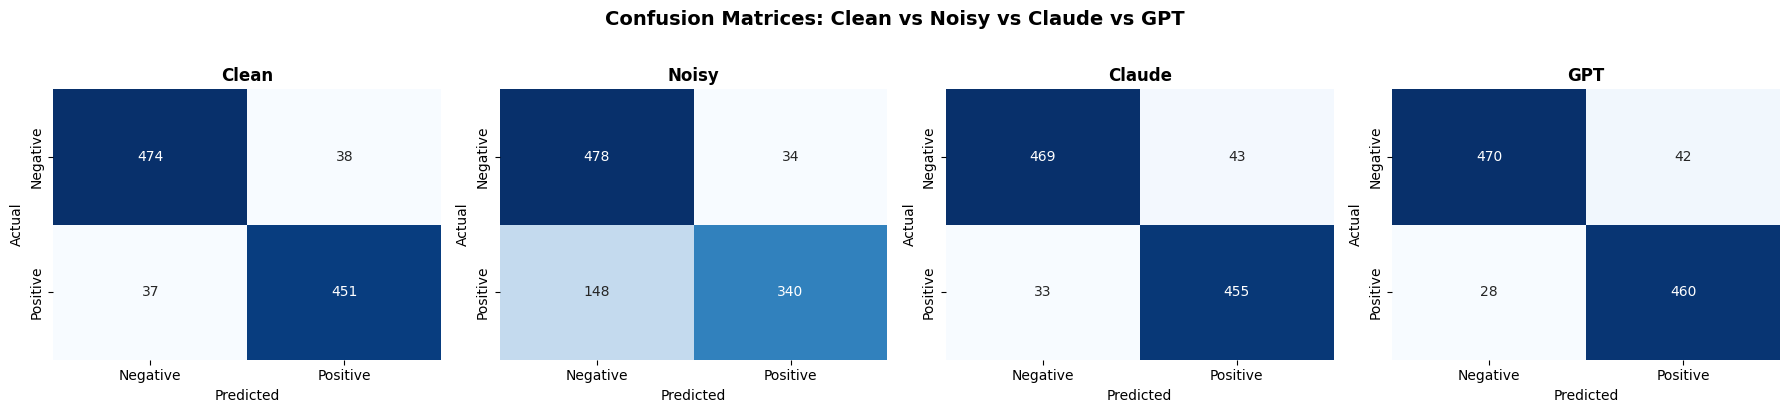

Saved 'confusion_matrices.png'
2/3: Creating accuracy comparison chart...


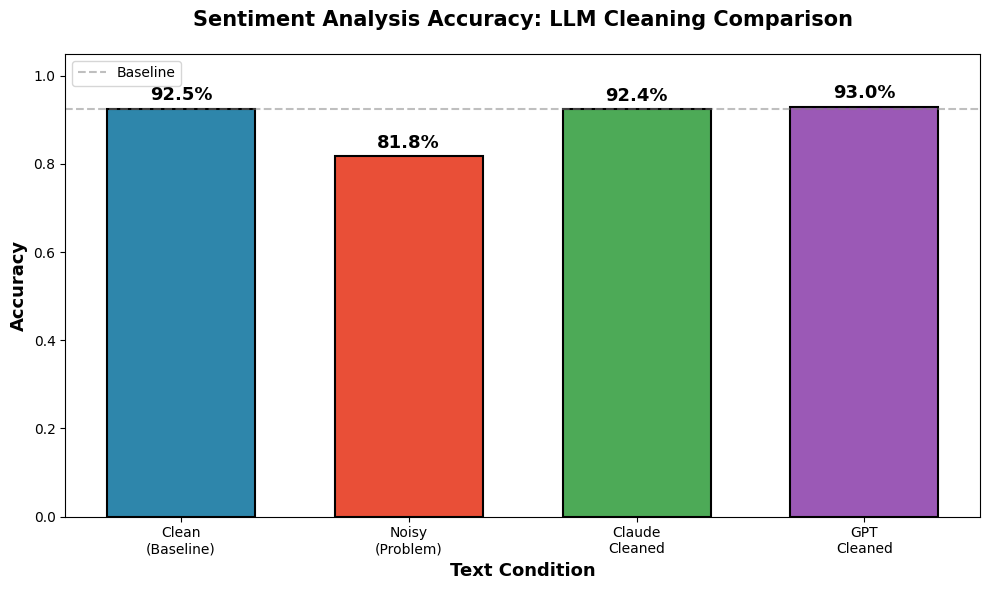

Saved 'accuracy_comparison.png'
3/3: Creating all metrics comparison chart...


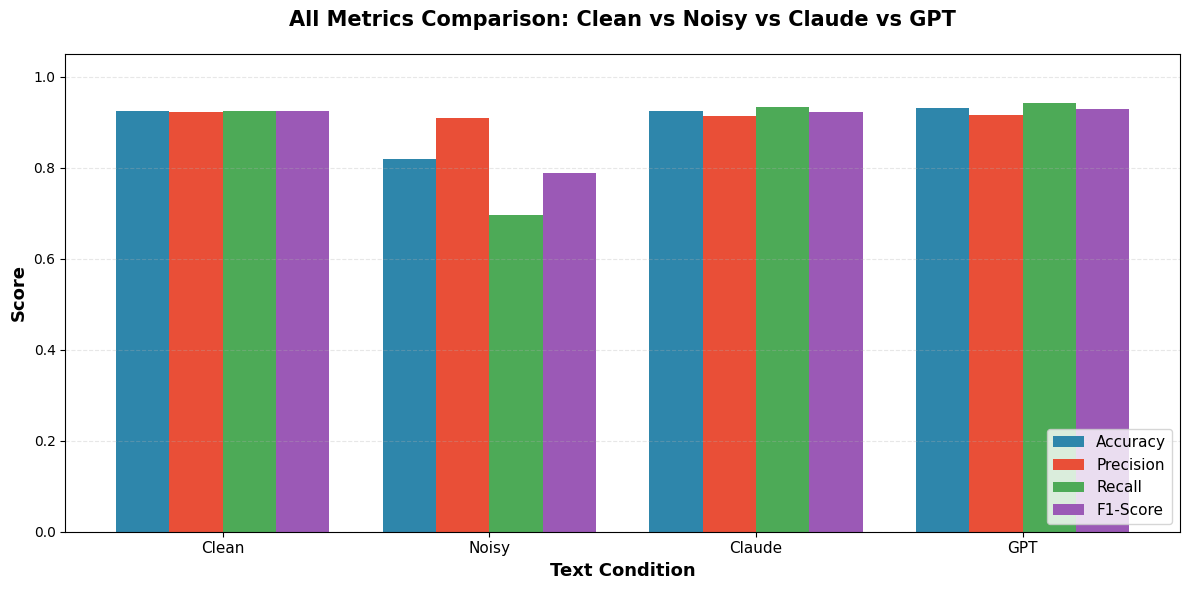

Saved 'all_metrics_comparison.png'

All visualizations complete

Generated files:
  confusion_matrices.png
  accuracy_comparison.png
  all_metrics_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All charts downloaded


In [ ]:
# =============================================================================
# Visualizations
# Generate confusion matrices and accuracy charts comparing all conditions
# =============================================================================

print("\nGenerating Visualizations")

# Store predictions
all_preds = {
    'Clean': clean_preds,
    'Noisy': noisy_preds,
    'Claude': claude_preds,
    'GPT': gpt_preds
}

# ----- CONFUSION MATRICES -----
print("1/3: Creating confusion matrices...")
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for idx, (name, preds) in enumerate(all_preds.items()):
    cm = confusion_matrix(df['label'], preds)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive'],
        cbar=False
    )
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.suptitle('Confusion Matrices: Clean vs Noisy vs Claude vs GPT',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved 'confusion_matrices.png'")

# ----- ACCURACY BAR CHART -----
print("2/3: Creating accuracy comparison chart...")
fig, ax = plt.subplots(figsize=(10, 6))

conditions = ['Clean\n(Baseline)', 'Noisy\n(Problem)', 'Claude\nCleaned', 'GPT\nCleaned']
accuracies = [clean_acc, noisy_acc, claude_acc, gpt_acc]
colors = ['#2E86AB', '#E94F37', '#4DAA57', '#9B59B6']

bars = ax.bar(conditions, accuracies, color=colors, width=0.65, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., height + 0.01,
        f'{acc:.1%}',
        ha='center', va='bottom',
        fontsize=13, fontweight='bold'
    )

ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_xlabel('Text Condition', fontsize=13, fontweight='bold')
ax.set_title('Sentiment Analysis Accuracy: LLM Cleaning Comparison',
             fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(0, 1.05)
ax.axhline(y=clean_acc, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Baseline')
ax.legend()

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved 'accuracy_comparison.png'")

# ----- ALL METRICS BAR CHART -----
print("3/3: Creating all metrics comparison chart...")
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(conditions))
width = 0.2

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_metrics = ['#2E86AB', '#E94F37', '#4DAA57', '#9B59B6']

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    values = results_df[metric].tolist()
    offset = (i - 1.5) * width
    ax.bar(x + offset, values, width, label=label, color=colors_metrics[i])

ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_xlabel('Text Condition', fontsize=13, fontweight='bold')
ax.set_title('All Metrics Comparison: Clean vs Noisy vs Claude vs GPT',
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(['Clean', 'Noisy', 'Claude', 'GPT'], fontsize=11)
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('all_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved 'all_metrics_comparison.png'")

print("\nAll visualizations complete")
print("\nGenerated files:")
print("  confusion_matrices.png")
print("  accuracy_comparison.png")
print("  all_metrics_comparison.png")

# Download all visualizations on Colab
if IS_COLAB:
    from google.colab import files
    files.download('confusion_matrices.png')
    files.download('accuracy_comparison.png')
    files.download('all_metrics_comparison.png')
    print("All charts downloaded")

In [ ]:
# =============================================================================
# Example Reviews Analysis
# Show specific examples where noise affected predictions
# =============================================================================

print("\nExample Reviews Analysis")

# Find examples where noise flipped the prediction but LLMs recovered
print("Finding examples where LLM cleaning recovered from noise...")

examples_found = 0
max_examples = 5

for i in range(len(df)):
    true_label = df['label'].iloc[i]
    clean_pred = clean_preds[i]
    noisy_pred = noisy_preds[i]
    claude_pred = claude_preds[i]
    gpt_pred = gpt_preds[i]

    # Find cases where clean was correct, noisy was wrong, and at least one LLM recovered
    if clean_pred == true_label and noisy_pred != true_label:
        if claude_pred == true_label or gpt_pred == true_label:
            examples_found += 1

            sentiment_name = "Positive" if true_label == 1 else "Negative"

            print(f"\nExample {examples_found}: True Sentiment = {sentiment_name}")
            print(f"CLEAN (Predicted: {['Negative', 'Positive'][clean_pred]}):")
            print(f"  {df['text'].iloc[i][:180]}...")
            print(f"NOISY (Predicted: {['Negative', 'Positive'][noisy_pred]}):")
            print(f"  {df['noisy_text'].iloc[i][:180]}...")
            print(f"CLAUDE (Predicted: {['Negative', 'Positive'][claude_pred]}):")
            print(f"  {df['claude_cleaned'].iloc[i][:180]}...")
            print(f"GPT (Predicted: {['Negative', 'Positive'][gpt_pred]}):")
            print(f"  {df['gpt_cleaned'].iloc[i][:180]}...")

            if examples_found >= max_examples:
                break

if examples_found == 0:
    print("No examples found where LLM cleaning recovered from noise-induced errors")
    print("This might indicate:")
    print("  - Noise level is too low")
    print("  - Model is robust to current noise types")
    print("  - Need to add more aggressive noise types")


Example Reviews Analysis
Finding examples where LLM cleaning recovered from noise...

Example 1: True Sentiment = Positive
CLEAN (Predicted: Positive):
  Dirty Harry goes to Atlanta is what Burt called this fantastic, first-rate detective thriller that borrows some of its plot from the venerable Dana Andrews movie "Laura." Not only ...
NOISY (Predicted: Negative):
  Dirty Harry goes to AAAtlanta is what Burt cAlleD this faaantastic, first-artE thfiller tjaaat obrriws some of its plot froj the vEneRable Daaana Andrews MovIE "Laura." Not only de...
CLAUDE (Predicted: Positive):
  # Cleaned Movie Review

Dirty Harry Goes to Atlanta is what Burt called this fantastic, first-rate thriller that borrows some of its plot from the venerable Dana Andrews movie "Lau...
GPT (Predicted: Positive):
  Dirty Harry Goes to Atlanta is what Burt called this fantastic, first-rate thriller that borrows some of its plot from the venerable Dana Andrews movie "Laura." Not only does Burt ...

Example 2: True 

In [ ]:
print("\nAll steps finished successfully")
print("\nGenerated files:")
print("  sentiment_model/ (directory) - trained on clean data")
print("  clean_reviews.csv - original test reviews")
print("  noisy_reviews.csv - test reviews with synthetic noise")
print("  llm_cleaned_reviews.csv - contains both Claude & GPT cleaned versions")
print("  results.csv - performance metrics for all conditions")
print("  confusion_matrices.png - visualization")
print("  accuracy_comparison.png - visualization")
print("  all_metrics_comparison.png - visualization")


All steps finished successfully

Generated files:
  sentiment_model/ (directory) - trained on clean data
  clean_reviews.csv - original test reviews
  noisy_reviews.csv - test reviews with synthetic noise
  llm_cleaned_reviews.csv - contains both Claude & GPT cleaned versions
  results.csv - performance metrics for all conditions
  confusion_matrices.png - visualization
  accuracy_comparison.png - visualization
  all_metrics_comparison.png - visualization
